In [1]:
import os
import json
import numpy as np
import MDAnalysis as mda
from paprika.io import json_numpy_obj_hook, NumpyEncoder

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

In [2]:
import logging
from importlib import reload

reload(logging)

logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(message)s',
    datefmt='%Y-%m-%d %I:%M:%S %p',
    level=logging.INFO
)

### Initialize

In [3]:
topology = "cb7-amt-sol.prmtop"
trajectory = "production-v1.nc"
selection = "resname WAT and (cyzone 4 30 20 resname CB7)"
folder = "windows"

with open("windows.json", "r") as f:
    window_list = json.loads(f.read(), object_hook=json_numpy_obj_hook)
pull_windows = window_list["pull"]["windows"]

n_water = {
    window: {"n_water": [], "hist": None} for window in pull_windows
}

### Count the number of water molecules

In [4]:
for window in pull_windows:
    
    logging.info(
        f"Counting number of water molecules in window {window}..."
    )
    
    # Define Universe
    universe = mda.Universe(
        os.path.join(folder, window, topology),
        os.path.join(folder, window, trajectory),
    )
    water = universe.select_atoms(
        selection,
        periodic=False,
        updating=True,
    )
    
    # Count the number of atoms
    n_atoms = []
    for ts in universe.trajectory:
        n_atoms.append(np.unique(water.resids).size)
        
    n_water[window]["n_water"] = np.array(n_atoms)
    
    del universe
    del water

2021-01-20 11:44:20 AM Counting number of water molecules in CB7 cavity in window p000...
2021-01-20 11:44:33 AM Counting number of water molecules in CB7 cavity in window p001...
2021-01-20 11:44:46 AM Counting number of water molecules in CB7 cavity in window p002...
2021-01-20 11:44:58 AM Counting number of water molecules in CB7 cavity in window p003...
2021-01-20 11:45:11 AM Counting number of water molecules in CB7 cavity in window p004...
2021-01-20 11:45:23 AM Counting number of water molecules in CB7 cavity in window p005...
2021-01-20 11:45:36 AM Counting number of water molecules in CB7 cavity in window p006...
2021-01-20 11:45:49 AM Counting number of water molecules in CB7 cavity in window p007...
2021-01-20 11:46:02 AM Counting number of water molecules in CB7 cavity in window p008...
2021-01-20 11:46:16 AM Counting number of water molecules in CB7 cavity in window p009...
2021-01-20 11:46:29 AM Counting number of water molecules in CB7 cavity in window p010...
2021-01-20

### Histogram

In [5]:
bin_edges = np.arange(0, 24, 1)
for window in pull_windows:
    # Generate Histogram
    logging.info(f"Creating histogram in window {window}...")
    hist, _ = np.histogram(n_water[window]["n_water"], bins=bin_edges, density=False)
    n_water[window]["hist"] = hist

2021-01-20 11:54:10 AM Creating histogram in window p000...
2021-01-20 11:54:10 AM Creating histogram in window p001...
2021-01-20 11:54:10 AM Creating histogram in window p002...
2021-01-20 11:54:10 AM Creating histogram in window p003...
2021-01-20 11:54:10 AM Creating histogram in window p004...
2021-01-20 11:54:10 AM Creating histogram in window p005...
2021-01-20 11:54:10 AM Creating histogram in window p006...
2021-01-20 11:54:10 AM Creating histogram in window p007...
2021-01-20 11:54:10 AM Creating histogram in window p008...
2021-01-20 11:54:10 AM Creating histogram in window p009...
2021-01-20 11:54:10 AM Creating histogram in window p010...
2021-01-20 11:54:10 AM Creating histogram in window p011...
2021-01-20 11:54:10 AM Creating histogram in window p012...
2021-01-20 11:54:10 AM Creating histogram in window p013...
2021-01-20 11:54:10 AM Creating histogram in window p014...
2021-01-20 11:54:10 AM Creating histogram in window p015...
2021-01-20 11:54:10 AM Creating histogra

(0.0, 500.0)

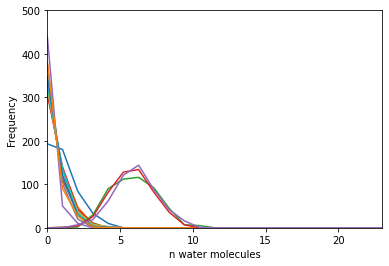

In [18]:
x = np.linspace(0, bin_edges[-1], len(n_water["p000"]["hist"]))
for index, window in enumerate(pull_windows):
    if index == 15:
        break
    plt.plot(x, n_water[window]["hist"])
plt.xlabel("n water molecules")
plt.ylabel("Frequency")
plt.xlim(0, bin_edges[-1])
plt.ylim(0, 500)

### Overlap Analysis 

In [7]:
def return_intersection(hist1, hist2):
    minima = np.minimum(hist1, hist2)
    intersect_1 = np.true_divide(np.sum(minima), np.sum(hist1))
    intersect_2 = np.true_divide(np.sum(minima), np.sum(hist2))
    return np.array([intersect_1, intersect_2])

In [8]:
n_windows = len(pull_windows)
n_water["overlap"] = np.zeros(n_windows)

for index in range(n_windows-1):
    iwindow = pull_windows[index]
    jwindow = pull_windows[index+1]
    
    hist1 = n_water[iwindow]["hist"]
    hist2 = n_water[jwindow]["hist"]
    intersection = return_intersection(hist1, hist2)
    n_water["overlap"][index] = intersection[0]

n_water["overlap"][index+1] = intersection[1]

In [9]:
with open("water_analysis.json", "w") as f:
    dumped = json.dumps(n_water, cls=NumpyEncoder)
    f.write(dumped)

### Plot Overlap and PMF

In [10]:
with open("APR_results.json", "r") as f:
    results = json.loads(f.read(), object_hook=json_numpy_obj_hook)

Text(0.5, 1.0, 'Overlap between neighbouring windows')

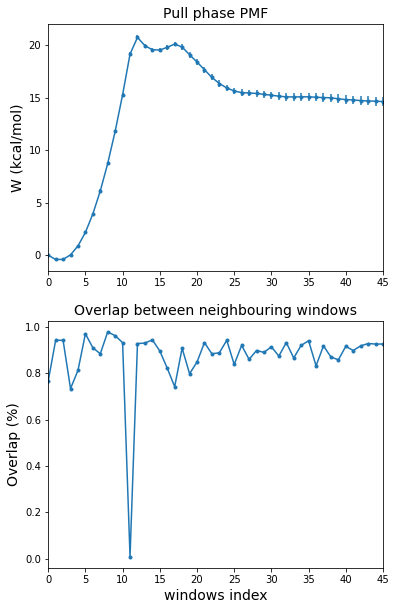

In [12]:
plt.figure(figsize=(6,10))

plt.subplot(2,1,1)
plt.errorbar(
    range(len(results["pull"]["ti-block"]["fe_matrix"][0,:])),
    results["pull"]["ti-block"]["fe_matrix"][0,:],
    yerr=results["pull"]["ti-block"]["sem_matrix"][0,:],
    fmt=".-",
)
plt.xlim(0, n_windows-1)
plt.title("Pull phase PMF", fontsize=14)
plt.ylabel("W (kcal/mol)", fontsize=14)

plt.subplot(2,1,2)
plt.plot(n_water["overlap"], '.-')
plt.xlim(0, n_windows-1)
plt.xlabel("windows index", fontsize=14)
plt.ylabel("Overlap (%)", fontsize=14)
plt.title("Overlap between neighbouring windows", fontsize=14)